In [72]:
import os;
import json;
import builtins
import duckdb
import pandas as pd;
import matplotlib.pyplot as plt
import numpy as np

def get_dataset_from_testcase(run):
    return run[6:-2]

dir = '/home/chesetti/Repos/learned_merge_cleanup/sponge/pgm_sampled'
index_stats = []
for test_case in os.listdir(dir):
    if test_case == 'build':
        continue
    for run_name in os.listdir(os.path.join(dir, test_case, 'input_results', 'run')):
        json_file = builtins.open(os.path.join(dir, test_case, 'input_results', 'run', run_name))
        run = (json.load(json_file))
        if 'index_stats' not in run['result']:
            continue
        for run_index_stats in run['result']['index_stats']:
            run_index_stats['dataset'] = get_dataset_from_testcase(test_case)
            index_stats.append(run_index_stats)
idf = pd.json_normalize(index_stats)
print(idf.columns)

Index(['index_build_duration', 'index_load_duration', 'index_name',
       'index_size', 'dataset'],
      dtype='object')


In [73]:
epsilon = {
    "pgm256": 256,
    "pgm1024": 1024,
    "pgm2048": 2048,
    "flatpgm256": 256,
    "flatpgm1024": 1024,
    "flatpgm2048": 2048,
    "sampledpgm256": 256,
    "sampledpgm1024": 1024,
    "sampledpgm2048": 2048,
    "flatpgm4096": 4096,
    "flatpgm8192": 8192,
    "hashjoin": 0,
    "btree256": 256,
    "btree1024": 1024,
    "btree2048": 2048,
    "sj": 0,
    "sj2": 0,
    "standard_merge": 0
};
def indexType(x):
    if "sampledpgm" in x:
        return "SAMPLED_PGM"
    if "flatpgm" in x:
        return "FLAT_PGM"
    elif "pgm" in x:
        return "PGM"
    elif "btree" in x:
        return "BTREE"
    return "NA"
idf['epsilon'] = idf['index_name'].map(lambda x: epsilon[x])
idf['index_type'] = idf['index_name'].map(lambda x: indexType(x))
# Per dataset
rows = duckdb.sql('SELECT * FROM idf')


In [74]:
def plot_index_memory(dataset, ax):
    rows = duckdb.sql(f"SELECT index_type, epsilon, index_size FROM idf WHERE dataset='{dataset}'").df()
    rows = rows.pivot(index='epsilon', values='index_size', columns='index_type').dropna()
    x = np.arange(len(rows.index))
    width = 0.15  # the width of the bars
    multiplier = 0
    for column in rows.columns:
        offset = width * multiplier
        rects = ax.bar(x + offset, rows[column], width, label=column)
        multiplier += 1
        ax.bar_label(rects, padding=3)
    ax.set_xticks(x + width, rows.index.astype(str))
    ax.set_ylabel('Size(B)')
    ax.set_xlabel('Epsilon')
    ax.legend(loc='upper right', ncols=3)
    ax.set_title('Index Size')

def plot_index_build(dataset, ax):
    rows = duckdb.sql(f"SELECT index_type, epsilon, index_build_duration FROM idf WHERE dataset='{dataset}'").df()
    rows = rows.pivot(index='epsilon', values='index_build_duration', columns='index_type').dropna()
    x = np.arange(len(rows.index))
    width = 0.25  # the width of the bars
    multiplier = 0
    for column in rows.columns:
        offset = width * multiplier
        rects = ax.bar(x + offset, rows[column], width, label=column)
        multiplier += 1
        ax.bar_label(rects, padding=3)
    ax.set_xticks(x + width, rows.index.astype(str))
    ax.legend(loc='upper right', ncols=3)
    ax.set_ylabel('Duration(ns)')
    ax.set_xlabel('Epsilon')
    ax.legend(loc='upper right', ncols=3)
    ax.set_title('Index Build Duration')
    
def plot_for_dataset(dataset):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    plot_index_memory(dataset, ax1)
    plot_index_build(dataset, ax2)
    fig.suptitle(f'dataset={dataset}', fontsize=16)
    plt.show()

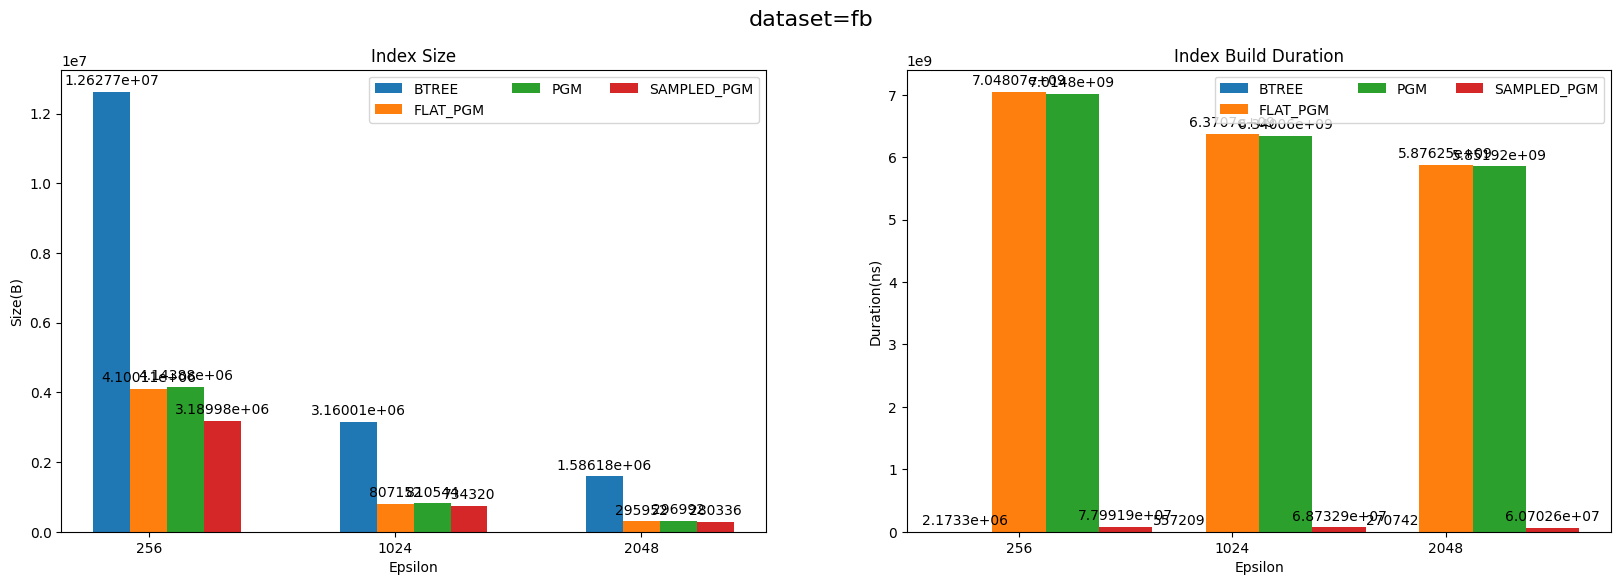

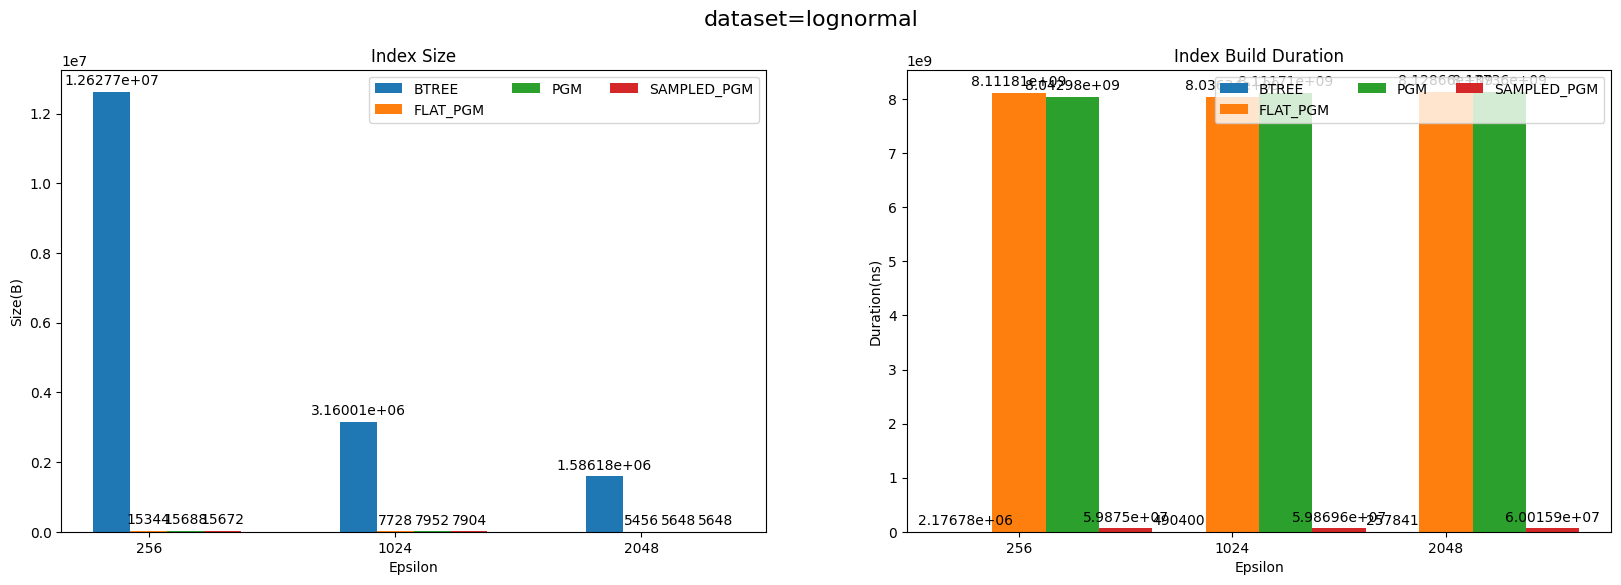

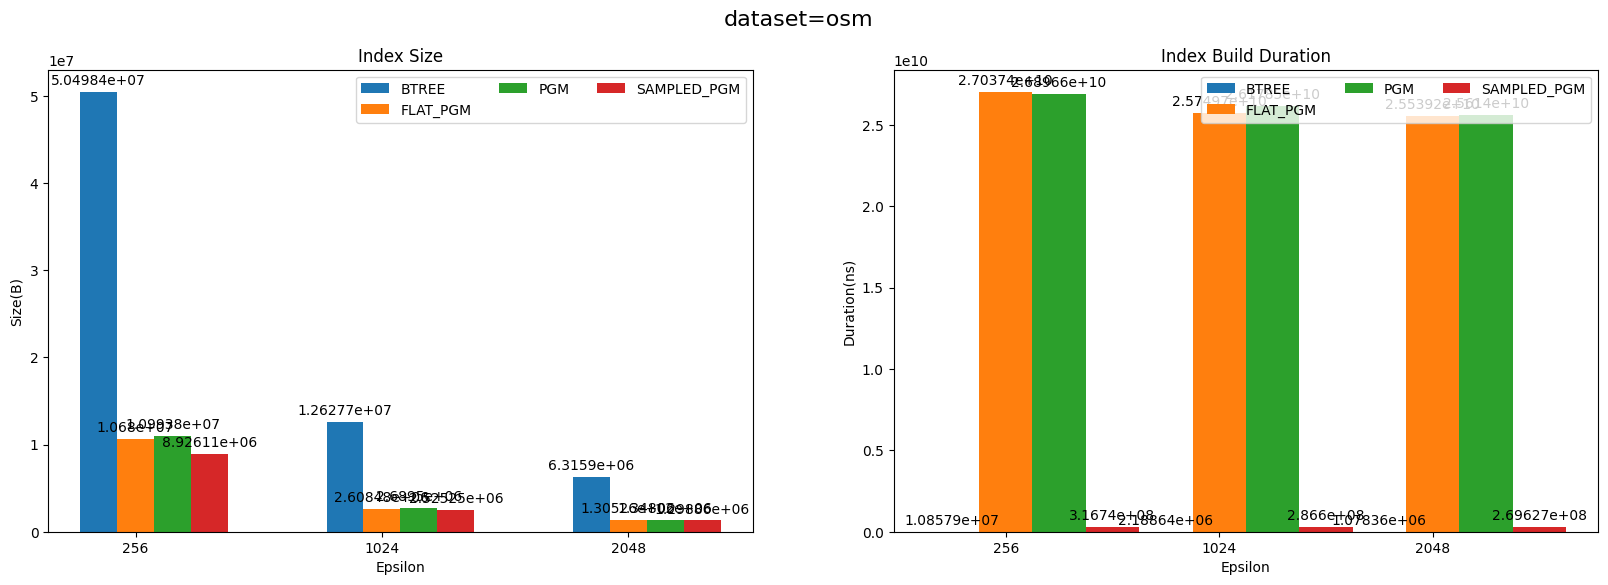

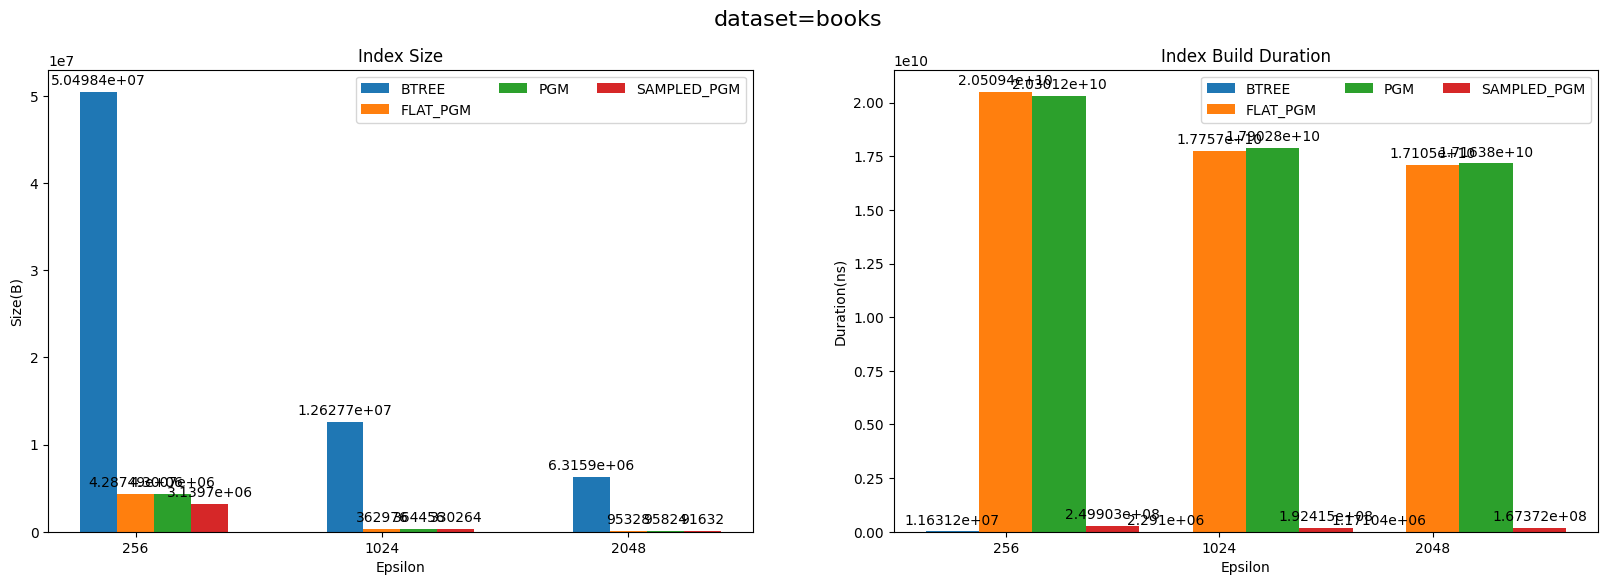

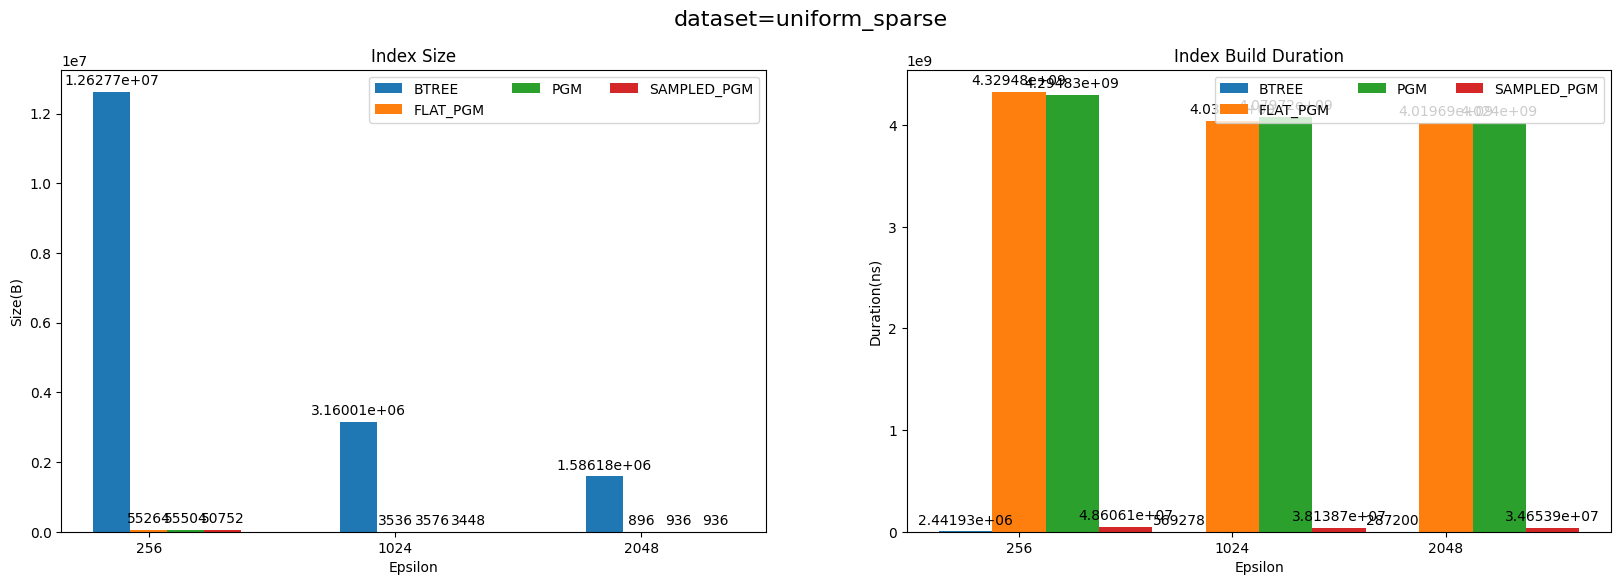

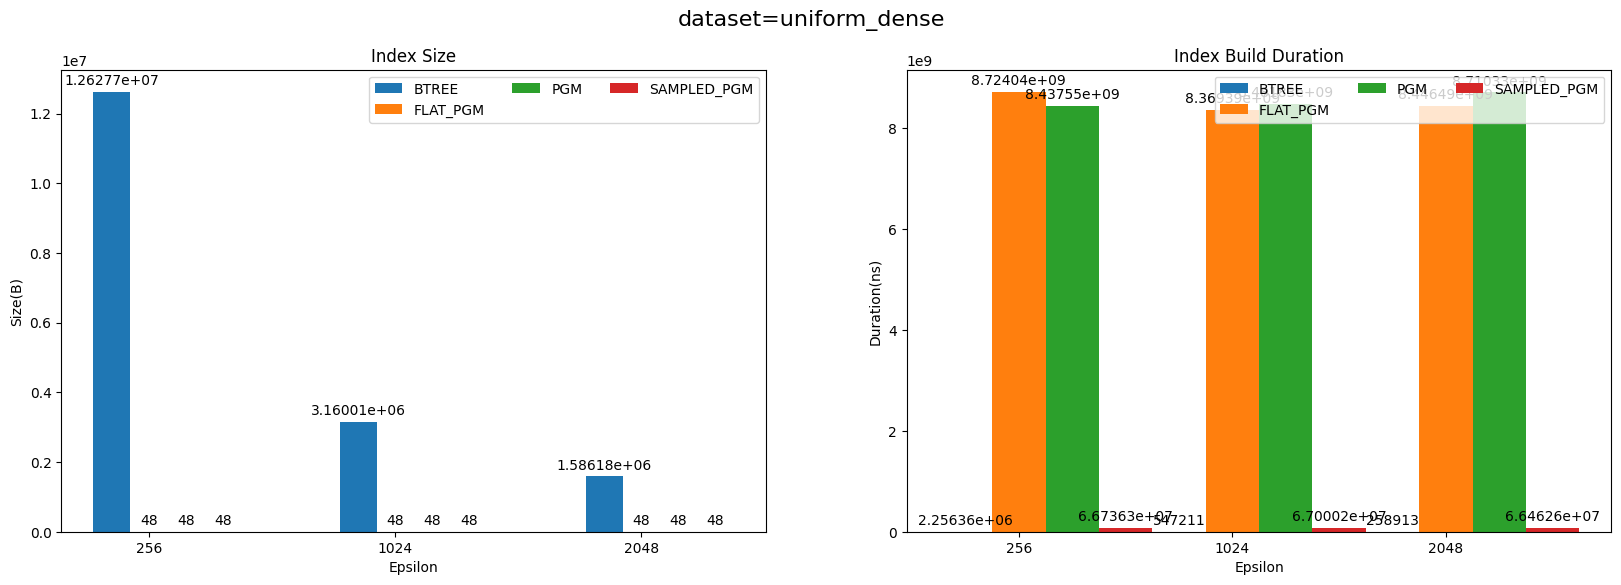

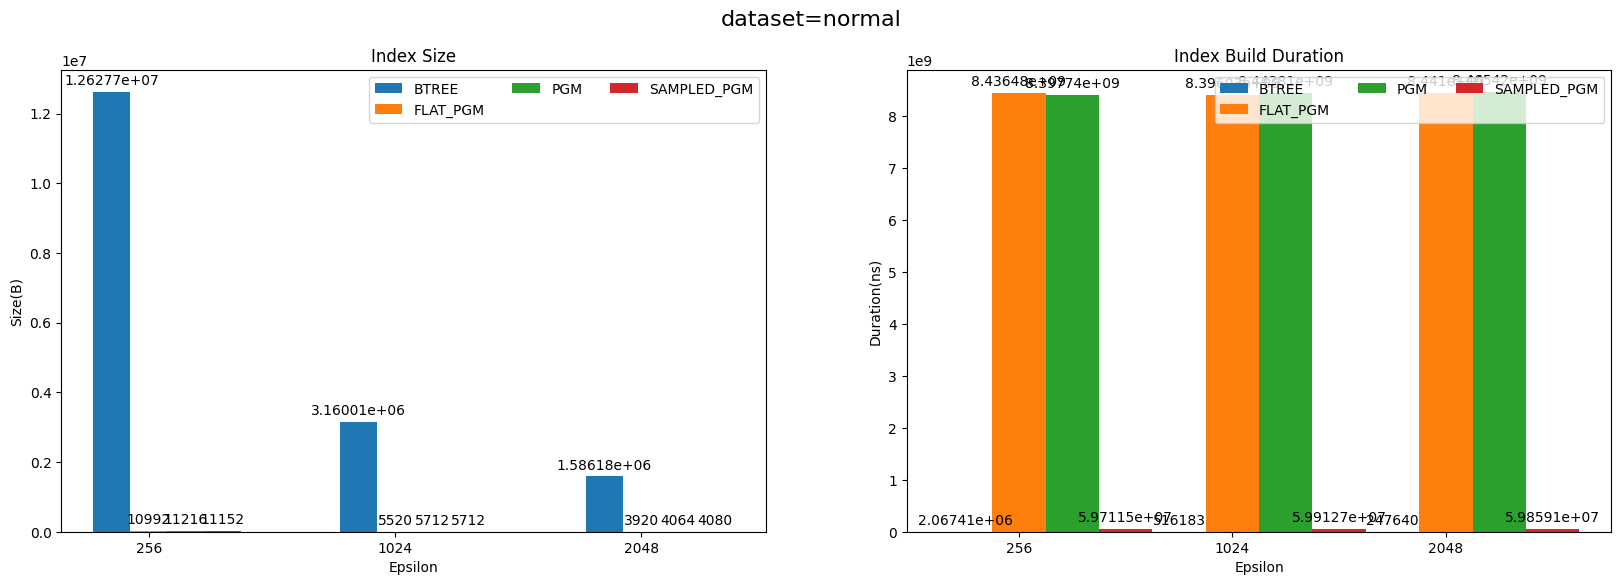

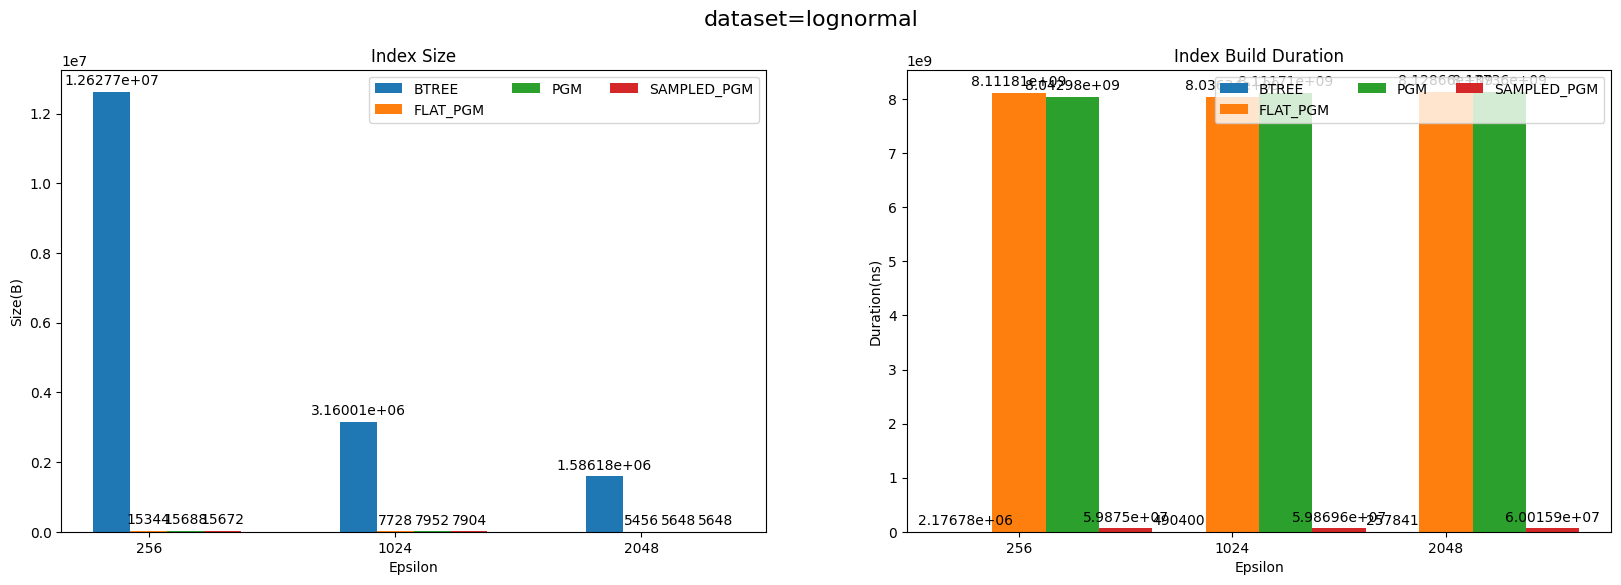

In [75]:
plot_for_dataset('fb')
plot_for_dataset('lognormal')
plot_for_dataset('osm')
plot_for_dataset('books')
plot_for_dataset('uniform_sparse')
plot_for_dataset('uniform_dense')
plot_for_dataset('normal')
plot_for_dataset('lognormal')

In [76]:
build_duration = duckdb.sql("SELECT index_type, epsilon,dataset, index_build_duration FROM idf WHERE epsilon < 4096").df()
build_duration = build_duration.pivot(index='epsilon', values='index_build_duration', columns=['dataset', 'index_type'])

index_size = duckdb.sql("SELECT index_type, index_size, epsilon, dataset FROM idf WHERE epsilon < 4096").df()
index_size = index_size.pivot(index='epsilon', values='index_size', columns=['dataset', 'index_type'])

datasets = ['fb', 'osm', 'wiki', 'books'] 
indexes = ['BTREE', 'PGM', 'SAMPLED_PGM']
columns = []
for dataset in datasets:
    for index in indexes:
        column = (dataset, index)
        columns.append(column)
        build_duration[column] = build_duration[column] / 1e9
        index_size[column] = index_size[column] / (1024 * 1024)
print(index_size[columns].to_latex(float_format='%.3f').replace('SAMPLED_PGM','PGM(S)').replace('uniform_dense', 'udense').replace('uniform_sparse', 'usparse').replace('_', '\_'))

datasets = ['uniform_dense', 'uniform_sparse', 'normal', 'lognormal'] 
columns = []
for dataset in datasets:
    for index in indexes:
        column = (dataset, index)
        columns.append(column)
        build_duration[column] = build_duration[column] / 1e9
        index_size[column] = index_size[column] / (1024 * 1024)
print(index_size[columns].to_latex(float_format='%.3f').replace('SAMPLED_PGM','PGM(S)').replace('uniform_dense', 'udense').replace('uniform_sparse', 'usparse').replace('_', '\_'))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
dataset & \multicolumn{3}{r}{fb} & \multicolumn{3}{r}{osm} & \multicolumn{3}{r}{wiki} & \multicolumn{3}{r}{books} \\
index\_type & BTREE & PGM & PGM(S) & BTREE & PGM & PGM(S) & BTREE & PGM & PGM(S) & BTREE & PGM & PGM(S) \\
epsilon &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
256 & 12.043 & 3.952 & 3.042 & 48.159 & 10.484 & 8.513 & 5.450 & 0.112 & 0.107 & 48.159 & 4.101 & 2.994 \\
1024 & 3.014 & 0.773 & 0.700 & 12.043 & 2.565 & 2.408 & 1.367 & 0.049 & 0.049 & 12.043 & 0.348 & 0.315 \\
2048 & 1.513 & 0.283 & 0.267 & 6.023 & 1.286 & 1.239 & 0.684 & 0.025 & 0.025 & 6.023 & 0.091 & 0.087 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
dataset & \multicolumn{3}{r}{fb} & \multicolumn{3}{r}{osm} & \multicolumn{3}{r}{wiki} & \multicolumn{3}{r}{books} & \multicolumn{3}{r}{udense} & \multicolumn{3}{r}{usparse} & \multicolumn{3}{r}{normal} & \multicolumn{3}{r}{lognormal} \\
index\_type & BTREE & PGM & PGM(S) & BTREE & PG

In [77]:
print(index_size)
for dataset in datasets:
    for index in indexes:
        pass
for dataset in synthetic_datasets:
datasts = ['uniform_dense', 'uniform_sparse', 'normal', 'lognormal'] 
    for index in indexes:
        column = (dataset, index)
        columns.append(column)
        build_duration[column] = build_duration[column] / 1e9
        index_size[column] = index_size[column] / (1024 * 1024)
print(index_size[columns].to_latex(float_format='%.3f'))

IndentationError: expected an indented block (1984291010.py, line 6)